In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.io
import pickle
import os
import copy as cp
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

## Example: Lissajous scanning pattern with the proposed design rule

(-1.0, 1.0)

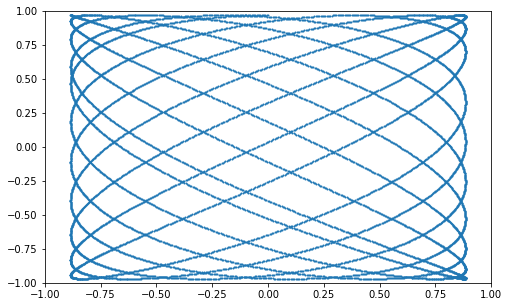

In [2]:
Q = 20
frx = 1.5
fry = 1.0
def transfer_func(fx, fy):
    Hx = 1/np.sqrt(((fx/frx)**2 - 1)**2 + (fx/frx/Q)**2) / Q
    Hy = 1/np.sqrt(((fy/fry)**2 - 1)**2 + (fy/fry/Q)**2) / Q
    return Hx, Hy

fx = 41/28.0
fy = 1.0
Hx, Hy = transfer_func(fx, fy)

t = np.arange(10000)/10000.0 * 14*np.pi + 14*np.pi
x = Hx * np.cos(fx*t) * 1.2
y = Hy * np.cos(fy*t) * 0.97
fig, ax = plt.subplots(1,1,figsize = (8,5))
plt.scatter(x,y, s = 1.0)
plt.xlim([-1.0, 1.0])
plt.ylim([-1.0, 1.0])

## Resampling raster scanned point cloud (from KITTI dataset) into Lissajous pattern scanned point cloud

In [3]:
from liss_simu_utils import Liss_Simu_Utils as LSU
root_path = os.getcwd()
kitti_calib = os.path.join(root_path, 'dataset/sequences/calib.txt')
lsu = LSU(kitti_calib)

[[ 4.27680239e-04 -9.99967248e-01 -8.08449168e-03 -1.19845993e-02]
 [-7.21062651e-03  8.08119847e-03 -9.99941316e-01 -5.40398473e-02]
 [ 9.99973865e-01  4.85948581e-04 -7.20693369e-03 -2.92196865e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 7.188560e+02  0.000000e+00  6.071928e+02  4.538225e+01]
 [ 0.000000e+00  7.188560e+02  1.852157e+02 -1.130887e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  3.779761e-03]]


In [4]:
## resampling, baseline pattern and optim pattern
kitti_path = os.path.join(root_path, 'dataset/velodyne/')
dmap_path = os.path.join(root_path, 'dense_dmap/')
fxs = [41/28.0, 11/7.0]
pxs = [0.0, np.pi/14]
pnames = ['fr1_5_optim', 'fr1_5_basic']

for pp in range(2):
    pname = pnames[pp]
    fx = fxs[pp]
    px = pxs[pp]
    
    kitti_save = os.path.join(root_path, 'dataset_splitscan_{}/velodyne/'.format(pname))
    if not os.path.exists(kitti_save):
        os.mkdir(os.path.join(root_path, 'dataset_splitscan_{}/'.format(pname)))
        os.mkdir(kitti_save)

    fy = 1.0
    Hx, Hy = transfer_func(fx, fy)

    for idx in tqdm(np.arange(800)):
        dmap = np.load(dmap_path + '%06d.npy'%(idx))
        pc_back, _ = lsu.solve_xyz_naive(dmap)
        velo = np.fromfile(kitti_path + '%06d.bin'%(idx), dtype = np.float32).reshape(-1,4)

        ## get scanning angle range
        rho_orig = np.sqrt(velo[:,1]**2 + velo[:,0]**2)
        theta_orig = np.arctan2(rho_orig, velo[:,2])
        phi_orig = np.arctan2(velo[:,1], velo[:,0])

        rho_back = np.sqrt(pc_back[:,1]**2 + pc_back[:,0]**2)
        theta_back = np.arctan2(rho_back, pc_back[:,2])
        phi_back = np.arctan2(pc_back[:,1], pc_back[:,0])

        theta_max = np.minimum(np.max(theta_orig), np.max(theta_back))
        theta_min = np.maximum(np.min(theta_orig), np.min(theta_back))
        phi_max = np.minimum(np.max(phi_orig), np.max(phi_back))
        phi_min = np.maximum(np.min(phi_orig), np.min(phi_back))

        t = np.arange(20000)/20000.0*14*np.pi + 14*idx*np.pi
        x = Hx * np.cos(fx*t + px) * 1.2
        y = Hy * np.cos(fy*t) * 0.97

        liss_x = (y + 1.0)/2.0
        liss_y = (x + 1.0)/2.0
        theta = (liss_x * (theta_max - theta_min) + theta_min).flatten()
        phi = (liss_y * (phi_max - phi_min) + phi_min).flatten()
        pc_back = lsu.get_lidar_data_noedge(dmap, theta, phi)

        split_filename = kitti_save + '%06d.bin'%(idx)
        pc_back.flatten().astype('float32').tofile(split_filename)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:23<00:00,  3.04it/s]


## Comparison on one data frame, resampled PC from baseline pattern and from proposed pattern

/tmp/ipykernel_1457/291381800.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


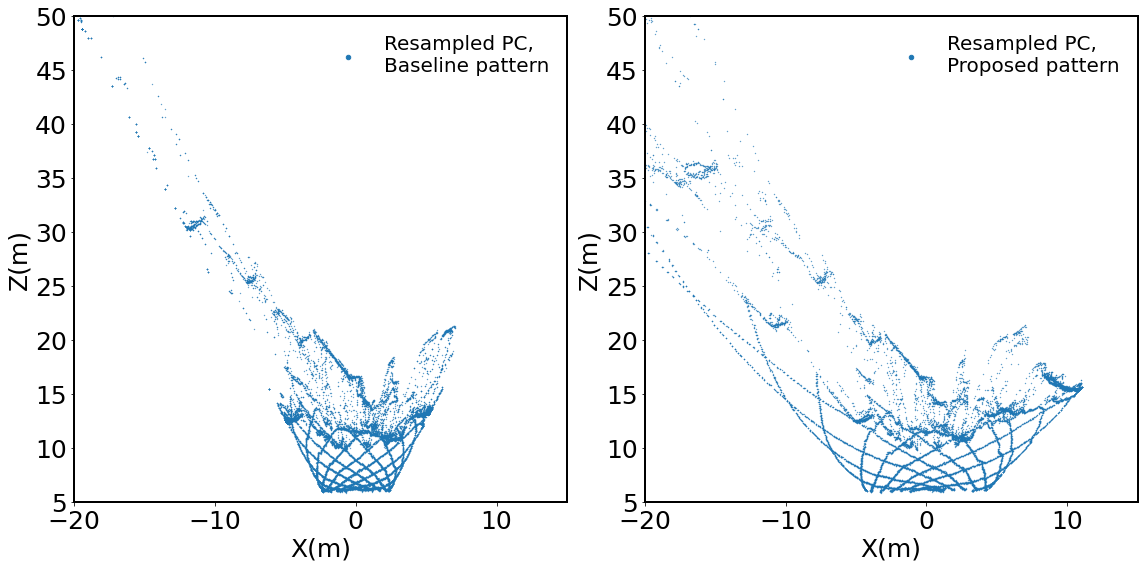

In [5]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.patches as patches

kitti_path1 = os.path.join(root_path, 'dataset_splitscan_fr1_5_basic/velodyne/')
kitti_path2 = os.path.join(root_path, 'dataset_splitscan_fr1_5_optim/velodyne/')

idx = 199
velo1 = np.fromfile(kitti_path1 + '%06d.bin'%(idx), dtype = np.float32).reshape(-1,4)
velo2 = np.fromfile(kitti_path2 + '%06d.bin'%(idx), dtype = np.float32).reshape(-1,4)

fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].scatter(velo1[:,1], velo1[:,0], s = 0.1)
ax[0].scatter(0,0,c = 'C0', s = 20.0, label = 'Resampled PC, \nBaseline pattern')

ax[1].scatter(velo2[:,1], velo2[:,0], s = 0.1)
ax[1].scatter(0,0,c = 'C0', s = 20.0, label = 'Resampled PC, \nProposed pattern')

for ii in np.arange(2):
    ax[ii].set_xlim([-20, 15])
    ax[ii].set_ylim([5, 50])
    ax[ii].tick_params(axis='x', labelsize= 25)
    ax[ii].tick_params(axis='y', labelsize= 25)
    ax[ii].set_xlabel('X(m)', fontsize = 25)
    ax[ii].set_ylabel('Z(m)', fontsize = 25)
    ax[ii].legend(loc=1, prop={'size': 20}, frameon = False)
    
    for axis in ['top','bottom','left','right']:
        ax[ii].spines[axis].set_linewidth(2.0)

plt.subplots_adjust(wspace = 0.2)
plt.tight_layout()

## Run adapted ALOAM scripts for laser odometry estimation

In [6]:
result_path1 = os.path.join(root_path, 'loam_splitscan_fr1_5_basic/')
result_path2 = os.path.join(root_path, 'loam_splitscan_fr1_5_optim/')

if not os.path.exists(result_path1):
    os.mkdir(result_path1)
    
if not os.path.exists(result_path2):
    os.mkdir(result_path2)

For baseline pattern, in 'catkin_kitti_aloam_liss/config.h' set 'PCL_DATA_SAVE_DIR' as '\[root_path\]/loam_splitscan_fr1_5_basic'. Set 'dataset_folder' as '\[root_path\]/dataset_splitscan_fr1_5_basic'. Then build with CMake and run <code>./build/aloam</code>


For optim pattern, in 'catkin_kitti_aloam_liss/config.h' set 'PCL_DATA_SAVE_DIR' as '\[root_path\]/loam_splitscan_fr1_5_optim'. Set 'dataset_folder' as '\[root_path\]/dataset_splitscan_fr1_5_optim'. Then build with CMake and run <code>./build/aloam</code>

## Compare results

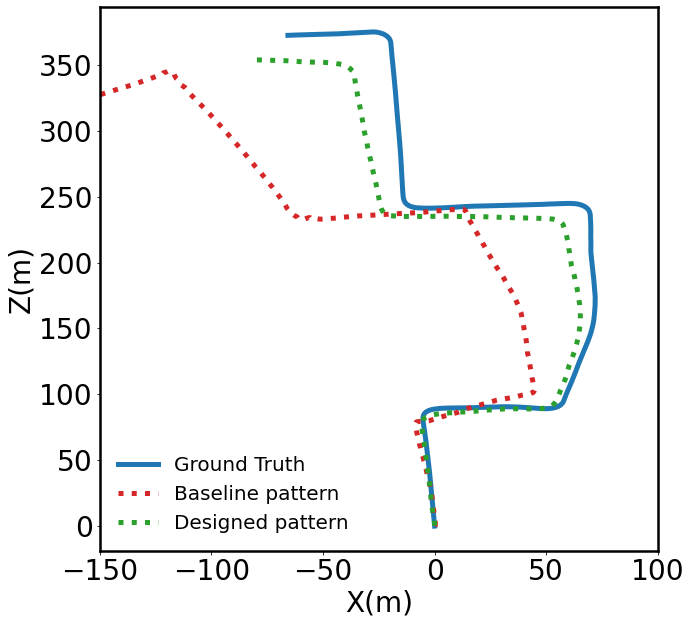

In [14]:
gt_path = os.path.join(root_path, 'dataset/gt.txt')
gt = np.asarray(np.loadtxt(gt_path, delimiter=' '))

odom_result1 = []
odom_result2 = []

for ii in np.arange(1,800):    
    odom_result1.append(np.loadtxt(result_path1 + 'odom_{}_{}.txt'.format(ii, ii+1)))

for ii in np.arange(1,800):    
    odom_result2.append(np.loadtxt(result_path2 + 'odom_{}_{}.txt'.format(ii, ii+1)))
    
odom_result1 = np.asarray(odom_result1)
odom_result2 = np.asarray(odom_result2)

fig, ax = plt.subplots(1,1,figsize = (10,10))
plt.plot(gt[:,3], gt[:,11], linewidth=5, label = 'Ground Truth')
plt.plot(odom_result1[:,4], odom_result1[:,6], ':', c = 'C3', linewidth=5, label = 'Baseline pattern')
plt.plot(odom_result2[:,4], odom_result2[:,6], ':', c = 'C2', linewidth=5, label = 'Designed pattern')
plt.tick_params(axis='x', labelsize= 20)
plt.tick_params(axis='y', labelsize= 20)

plt.xlim([-150,100])
plt.xlabel('X(m)', fontsize = 28)
plt.ylabel('Z(m)', fontsize = 28)
plt.legend(loc=3, prop={'size': 20}, frameon = False)

plt.tick_params(axis='x', labelsize= 28)
plt.tick_params(axis='y', labelsize= 28)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)